In [1]:
# !/usr/bin/env python3

#cd ~/Desktop/snet/gits/lang-learn-repo/alex_tests

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import sys  
import subprocess
import pywt as pywt

from sklearn import metrics
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

from mpl_toolkits import mplot3d

In [2]:
path = '~/Desktop/snet/gits/lang-learn-repo/alex_tests/data'
filenames = ['data11']
#dims = 3
#blocks = 3
limit = .95

In [3]:
def pcaSymbolize(df,dim=3,block=3):
    #divs = blocks**dim
    out = df.copy()
    
    for v in out.columns:
        out[v] = (out[v]-min(out[v]))/(max(out[v])-min(out[v]))
        
    out['sym']="R"
    out['num']=0
    
    for d in range(dim):
        out['sym'+str(d)]=0
        for b in range(block):
            out.loc[out.loc[:,out.columns[d]]>out.quantile((b+1)/float(block))[out.columns[d]],'sym'+str(d)]=b+1
    
    for c in range(dim):
        out['num']=out['num']+out['sym'+str(c)]*(block**(dim-c-1))
    out['sym']=out['sym']+out['num'].astype(str)
    
    return out
            

In [4]:
def pcaPlot(df,dim=3):
    out = df.copy()
    
    for v in out.columns:
        out[v] = (out[v]-min(out[v]))/(max(out[v])-min(out[v]))
        
    if dim==3:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter3D(out[out.columns[0]], out[out.columns[1]], out[out.columns[2]], c=out[out.columns[-1]], cmap='coolwarm');

/home/alexcasar/miniconda3/envs/ull/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


-7


,sym0,sym1,sym2,sym3,sym4,sym5,sym6
0,R100,R118,R124,R74,R124,R124,R31
1,R100,R118,R99,R74,R124,R124,R31
2,R100,R118,R69,R74,R124,R124,R31
3,R100,R118,R69,R74,R124,R124,R31
4,R100,R117,R69,R74,R124,R124,R31
5,R100,R117,R69,R74,R124,R115,R31
6,R100,R117,R69,R74,R124,R115,R31
7,R110,R117,R69,R74,R124,R115,R33
8,R110,R117,R69,R74,R124,R115,R31
9,R110,R118,R69,R74,R124,R115,R64


anomaly:		 31
non anomaly		 16

diffs
total with rep:		 47
total without rep:	 38
rep:			 9
rep%:			 56.25 %
rep%:			 76.31578947368422 %
------------------------------------------------------
anomaly:		 45
non anomaly		 15

diffs
total with rep:		 60
total without rep:	 52
rep:			 8
rep%:			 53.333333333333336 %
rep%:			 84.61538461538461 %
------------------------------------------------------
anomaly:		 57
non anomaly		 22

diffs
total with rep:		 79
total without rep:	 65
rep:			 14
rep%:			 63.63636363636363 %
rep%:			 78.46153846153847 %
------------------------------------------------------
anomaly:		 35
non anomaly		 22

diffs
total with rep:		 57
total without rep:	 41
rep:			 16
rep%:			 72.72727272727273 %
rep%:			 60.97560975609756 %
------------------------------------------------------
anomaly:		 34
non anomaly		 10

diffs
total with rep:		 44
total without rep:	 36
rep:			 8
rep%:			 80.0 %
rep%:			 77.77777777777779 %
----------------------------------------------------

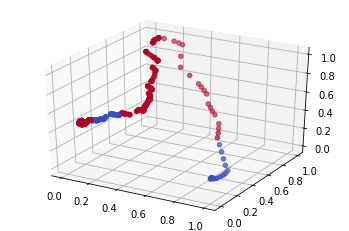

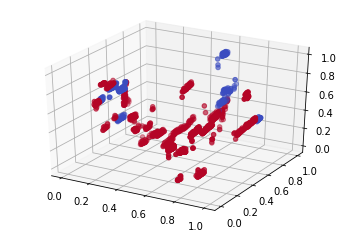

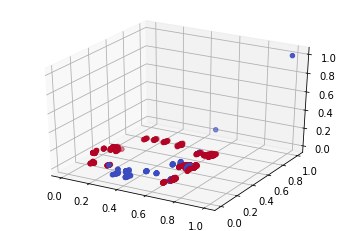

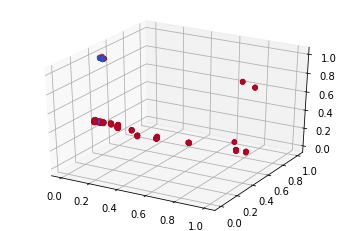

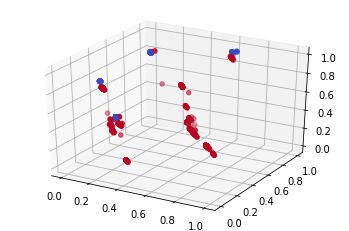

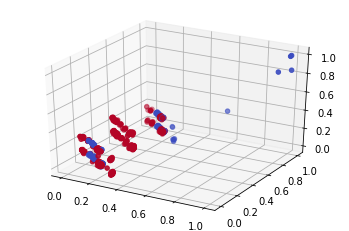

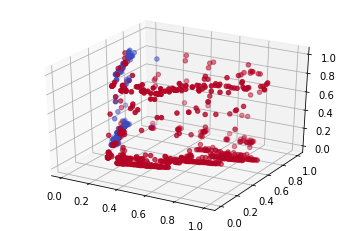

In [5]:
for filename in filenames:
    #filename = filenames[0]
    doc = pd.read_csv(path+"/"+filename+"/"+filename+".csv") 
    clst = pd.read_csv(path+"/"+filename+"/"+filename+"_clusters.csv")

    dataT = doc.copy()

    for v in dataT.columns:
        dataT[v] = (dataT[v]-min(dataT[v]))/(max(dataT[v])-min(dataT[v]))

    dataT = dataT.replace(np.nan,0)
    dataT = dataT.T
    data = dataT.iloc[:-1,:]
    data['clst']=list(clst['cluster'])

    for c in range(max(data['clst'])+1):
        sub = data.loc[data.loc[:,'clst']==c,data.columns[:-1]]
        sub = sub.T
        
        #Fitting the PCA algorithm with our Data
        pcaT = PCA().fit(sub)
        #plt.figure()
        #plt.plot(np.cumsum(pcaT.explained_variance_ratio_))
        varsum = pd.DataFrame(np.cumsum(pcaT.explained_variance_ratio_))
        dims = min(10,max(3,len(varsum.loc[limit>varsum.loc[:,0],0])))
        blocks = max(3,min(10,int(50/dims)))
        dims = 3
        blocks = 5
        
        #plt.xlabel('Number of Components')
        #plt.ylabel('Variance (%)') #for each component
        #plt.xlim(0,dims+1)
        #plt.title('Pulsar Dataset Explained Variance')
        #plt.show()
        
        pca = PCA(n_components=dims)
        pca.fit(sub)
        newSubs = pca.transform(sub)
        newSubs = pd.DataFrame(newSubs)
        newSub = pcaSymbolize(newSubs,dims,blocks)

        data = data.T
        data['sym'+str(c)]=0
        data.loc[:len(newSub['sym']),'sym'+str(c)]=list(newSub['sym'])
        data = data.T

        subput = newSubs.copy()
        subput['anomaly']=list(doc['anomaly'])
        pcaPlot(subput)
        #display(subput['anomaly'].describe())
        
    output = data.T
    lim = -int(max(data['clst'])+1)
    print(lim)
    output = output.loc[output.index[:-1],output.columns[lim:]]
    display(output)

    #output.to_csv(path+"/"+filename+"/"+filename+"_PCA_"+str(dims)+"_"+str(blocks)+".csv",index=False) 
    output['anomaly']=list(doc['anomaly'])
    outSY = output[output['anomaly']==1]
    outSN = output[output['anomaly']==0]
    
    for n in range(len(outSY.columns)):
        groupAns = outSY.groupby(by=outSY.columns[n]).count().iloc[:,0].index
        print('anomaly:\t\t',len(groupAns))
        groupNons = outSN.groupby(by=outSY.columns[n]).count().iloc[:,0].index
        print('non anomaly\t\t',len(groupNons))
        print("\ndiffs")
        listG = list(groupAns)+list(groupNons)
        setG = set(listG)
        print("total with rep:\t\t",len(listG))
        print("total without rep:\t",len(setG))
        print("rep:\t\t\t",len(listG)-len(setG))
        print("rep%:\t\t\t",100*(len(listG)-len(setG))/min(len(groupAns),len(groupNons)),'%')
        print("rep%:\t\t\t",100*(1-(len(listG)-len(setG))/len(setG)),'%')
        print('------------------------------------------------------')
    
    

In [6]:
display(data)

,0,1,2,3,4,5,6,7,8,9,...,1144,1145,1146,1147,1148,1149,1150,1151,1152,clst
Cisco-IOS-XR-infra-statsd-oper_infra-statistics_interfaces_interface_cache_data-rate_bandwidth_HundredGigE0/0/0/1,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,2
Cisco-IOS-XR-infra-statsd-oper_infra-statistics_interfaces_interface_cache_data-rate_bandwidth_HundredGigE0/0/0/10,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisco-IOS-XR-infra-statsd-oper_infra-statistics_interfaces_interface_cache_data-rate_bandwidth_HundredGigE0/0/0/11,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisco-IOS-XR-infra-statsd-oper_infra-statistics_interfaces_interface_cache_data-rate_bandwidth_HundredGigE0/0/0/12,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisco-IOS-XR-infra-statsd-oper_infra-statistics_interfaces_interface_cache_data-rate_bandwidth_HundredGigE0/0/0/13,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisco-IOS-XR-infra-statsd-oper_infra-statistics_interfaces_interface_cache_data-rate_bandwidth_HundredGigE0/0/0/14,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisco-IOS-XR-infra-statsd-oper_infra-statistics_interfaces_interface_cache_data-rate_bandwidth_HundredGigE0/0/0/15,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisco-IOS-XR-infra-statsd-oper_infra-statistics_interfaces_interface_cache_data-rate_bandwidth_HundredGigE0/0/0/16,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisco-IOS-XR-infra-statsd-oper_infra-statistics_interfaces_interface_cache_data-rate_bandwidth_HundredGigE0/0/0/17,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
Cisco-IOS-XR-infra-statsd-oper_infra-statistics_interfaces_interface_cache_data-rate_bandwidth_HundredGigE0/0/0/18,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


In [7]:
output = data.T
output = output.loc[output.index[:-1],output.columns[-7:]]
output['anomaly']=list(doc['anomaly'])
outSY = output[output['anomaly']==1]
outSN = output[output['anomaly']==0]
display(output)

,sym0,sym1,sym2,sym3,sym4,sym5,sym6,anomaly
0,R100,R118,R124,R74,R124,R124,R31,0
1,R100,R118,R99,R74,R124,R124,R31,0
2,R100,R118,R69,R74,R124,R124,R31,0
3,R100,R118,R69,R74,R124,R124,R31,0
4,R100,R117,R69,R74,R124,R124,R31,0
5,R100,R117,R69,R74,R124,R115,R31,0
6,R100,R117,R69,R74,R124,R115,R31,0
7,R110,R117,R69,R74,R124,R115,R33,0
8,R110,R117,R69,R74,R124,R115,R31,0
9,R110,R118,R69,R74,R124,R115,R64,0


In [8]:
output['anomaly']=list(doc['anomaly'])
outSY = output[output['anomaly']==1]
outSN = output[output['anomaly']==0]

In [9]:
for n in range(len(outSY.columns)):
    print('anomaly')
    groupAns = outSY.groupby(by=outSY.columns[n]).count().iloc[:,0].index
    print(len(groupAns))
    print('non anomaly')
    groupNons = outSN.groupby(by=outSY.columns[n]).count().iloc[:,0].index
    print(len(groupNons))
    print("diffs")
    listG = list(groupAns)+list(groupNons)
    setG = set(listG)
    print("total with rep:\t\t",len(listG))
    print("total without rep:\t",len(setG))
    print("rep:\t\t\t",len(listG)-len(setG))

anomaly
31
non anomaly
16
diffs
total with rep:		 47
total without rep:	 38
rep:			 9
anomaly
45
non anomaly
15
diffs
total with rep:		 60
total without rep:	 52
rep:			 8
anomaly
57
non anomaly
22
diffs
total with rep:		 79
total without rep:	 65
rep:			 14
anomaly
35
non anomaly
22
diffs
total with rep:		 57
total without rep:	 41
rep:			 16
anomaly
34
non anomaly
10
diffs
total with rep:		 44
total without rep:	 36
rep:			 8
anomaly
84
non anomaly
32
diffs
total with rep:		 116
total without rep:	 88
rep:			 28
anomaly
62
non anomaly
29
diffs
total with rep:		 91
total without rep:	 72
rep:			 19
anomaly
1
non anomaly
1
diffs
total with rep:		 2
total without rep:	 2
rep:			 0


In [10]:
clsts = pd.read_csv(path+"/"+filenames[0]+"/"+filenames[0]+"_clusters.csv")
for filename in filenames[1:]:
    clst = pd.read_csv(path+"/"+filename+"/"+filename+"_clusters.csv")
    clsts = pd.merge(clsts,clst, on='var')
clsts.columns = ['var']+filenames
clsts = clsts.sort_values(by='var')
display(clsts)

,var,data11
0,Cisco-IOS-XR-infra-statsd-oper_infra-statistic...,2
1,Cisco-IOS-XR-infra-statsd-oper_infra-statistic...,0
2,Cisco-IOS-XR-infra-statsd-oper_infra-statistic...,0
3,Cisco-IOS-XR-infra-statsd-oper_infra-statistic...,0
4,Cisco-IOS-XR-infra-statsd-oper_infra-statistic...,0
5,Cisco-IOS-XR-infra-statsd-oper_infra-statistic...,0
6,Cisco-IOS-XR-infra-statsd-oper_infra-statistic...,0
7,Cisco-IOS-XR-infra-statsd-oper_infra-statistic...,0
8,Cisco-IOS-XR-infra-statsd-oper_infra-statistic...,0
9,Cisco-IOS-XR-infra-statsd-oper_infra-statistic...,0
